In [2]:
import numpy as np
import pandas as pd
import pickle 
import random
import matplotlib.pyplot as plt
import joblib
import requests
from bs4 import BeautifulSoup as bs
from datetime import date
!pip install draftfast
import draftfast

In [3]:
import keras
from keras.layers import Dense, Flatten, Reshape, Input
from keras.layers import  Dense, Lambda, dot, Activation, concatenate, LSTM, BatchNormalization, TimeDistributed
from keras.models import Sequential, Model
from keras.callbacks import History 
from keras.layers import Activation, Dropout, Flatten, Dense

In [4]:
#Load scalers and data into memory 
scaler_x = joblib.load('scaler_x.pkl')
scaler_y = joblib.load('scaler_y.pkl')

#Format and get unqiue players 
df_scaled = pd.read_csv("Test.csv")
del df_scaled['Unnamed: 0']
lb = 10
players = df_scaled['Starters'].unique()


def format(df_scaled, lb):
  """
  format: takes a dataframe of players stat lines and returns a 3d array of rolling stats, 1d array of actual points
  and a 2d array of the opposing teams defensive stats

  param df_scaled: A dataframe that is normalized where each row is a players stat line in a given game. Score is for that game
  param lb: How many games in the past to include in one sample.
  """
  x_list = []
  y_list = []
  def_list = []

  for player in (players):
      #Grab only the games played by this player. Sort on data so past five games are correct
      ar_mid = df_scaled[df_scaled['Starters'] == player]
      ar_mid = ar_mid.sort_values(by='DATE')
      ar_mid = ar_mid.values

      #Need at least lb + games to have been played be the player in order to have lb # of games for x data any 1 more to predict
      if ar_mid.shape[0] < lb+1:
          pass
      else:
          for i in range(0, ar_mid.shape[0] - lb):
              x = ar_mid[i: i + lb, 2:-1]
              y = ar_mid[i + lb, -1]
              x_list.append(x)
              y_list.append(y)

              def_stats = ar_mid[i + lb, -6:-2]
              def_list.append(def_stats)

              
  x_data = np.stack(x_list)
  y_data = np.stack(y_list)
  def_data = np.stack(def_list)
  return x_data, y_data, def_data

df_train = df_scaled.head(int(.8 * len(df_scaled)))
x_train, y_train, def_stats_train = format(df_train, lb)

df_test = df_scaled.tail(int(.2 * len(df_scaled)))
x_test, y_test, def_stats_test = format(df_train, lb)

x_train = np.asarray(x_train).astype('float32')
x_test = np.asarray(x_test).astype('float32')
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

x_train.shape, y_train.shape, x_test.shape, y_train.shape

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.0 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


((78533, 10, 32), (78533,), (78533, 10, 32), (78533,))

In [5]:
def attention_3d_block(hidden_states):

    hidden_size = int(hidden_states.shape[2])
    score_first_part = Dense(hidden_size, use_bias=False, name='attention_score_vec')(hidden_states)

    h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(hidden_states)
    score = dot([score_first_part, h_t], [2, 1], name='attention_score')
    attention_weights = Activation('softmax', name='attention_weight')(score)

    context_vector = dot([hidden_states, attention_weights], [1, 1], name='context_vector')
    pre_activation = concatenate([context_vector, h_t], name='attention_output')
    attention_vector = Dense(128, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)

    return attention_vector

history = History()
model = Sequential()

inp = Input(x_train[0].shape)
x = (LSTM(16, return_sequences=True))(inp)
x = (Dropout(.05))(x)
x = (BatchNormalization())(x)
x = (LSTM(32, return_sequences=True))(x)
x = (Dropout(.05))(x)
x = (LSTM(16, return_sequences=True))(x)
x = (Dropout(.05))(x)
attention_output = (attention_3d_block(x))
out = (Dense(1, activation = 'relu'))(x)

model = Model(inputs = inp, outputs = attention_output)
model.compile(
  optimizer='adam',
  loss='mean_squared_error'
)

model.summary()

model.fit(x_train, y_train,
          batch_size=100,
          epochs=5,
          verbose=1,
          shuffle = True,
          validation_data=(x_test, y_test),
          callbacks=[history])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 32)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 10, 16)       3136        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 10, 16)       0           lstm[0][0]                       
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 10, 16)       64          dropout[0][0]                    
______________________________________________________________________________________________

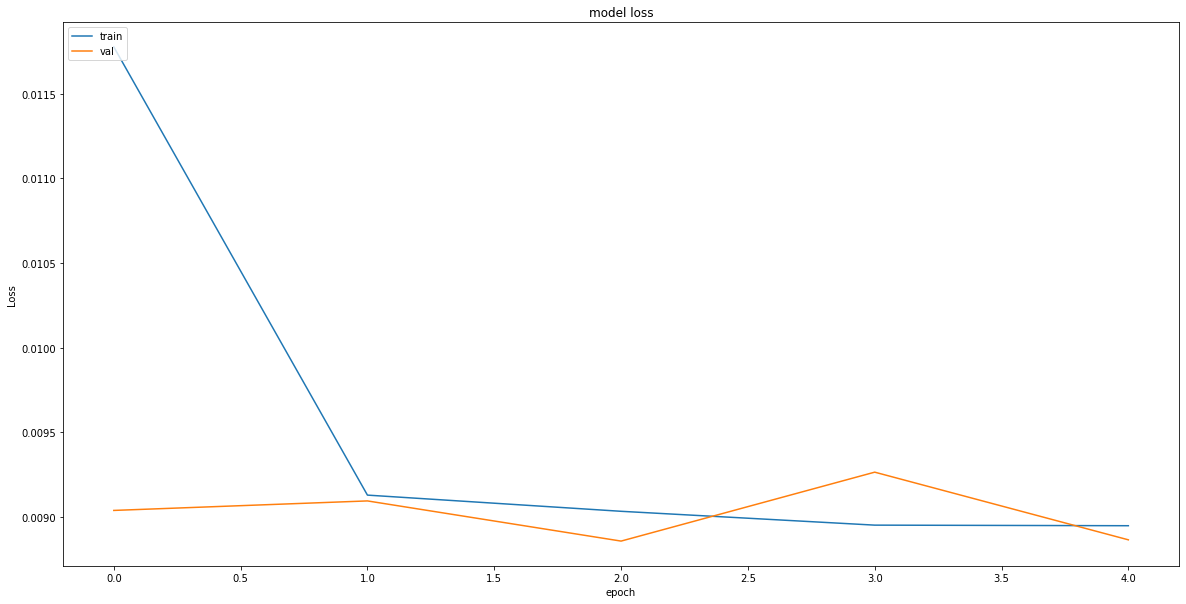

2455/2455 [==============================] - 10s 4ms/step - loss: 0.0089


0.008863121271133423

In [6]:
fig = plt.figure(figsize=(20,10))
ax = plt.subplot()

x = np.arange(0,len(history.history['loss']))

ax.plot(x,history.history['loss'])
ax.plot(x,history.history['val_loss'])


plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
model.evaluate(x_test, y_test)

In [7]:
from keras.models import model_from_json

model_json = model.to_json()

with open("MODEL.json", "w") as json_file:
      json_file.write(model_json)

model.save_weights("UP.h5")

In [8]:
df = pd.read_csv("Test.csv")
del df['Unnamed: 0']

In [9]:

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

co = 20

#########Training Data#############
df_train = df_scaled.head(int(.8 * len(df_scaled)))
x_train, y_train, def_stats_train = format(df_train, lb)
y_train = scaler_y.inverse_transform((y_train.reshape(-1,1)))

x_train = np.asarray(x_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')

_preds = model.predict(x_train)
preds_train = scaler_y.inverse_transform(_preds)
x_train = np.hstack((def_stats_train, preds_train))
####################a#############

#########Testing Data#############
df_test = df_scaled.tail(int(.2 * len(df_scaled)))
x_test, y_test, def_stats_test = format(df_test, lb)
y_test = scaler_y.inverse_transform((y_test.reshape(-1,1)))

x_test = np.asarray(x_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

_preds_test = model.predict(x_test)
preds_test = scaler_y.inverse_transform(_preds_test)
x_test = np.hstack((def_stats_test, preds_test))
##################################


print("Training XGB...")
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 3, alpha = 10, n_estimators = 100)
xg_reg.fit(x_train,y_train)
preds_xgb = xg_reg.predict(x_test)

print("Training RF")
RF_reg = RandomForestRegressor(n_estimators=20)
RF_reg.fit(x_train, y_train)
preds_rf = RF_reg.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, preds_rf))
print("RF RMSE: %f" % (rmse))

rmse = np.sqrt(mean_squared_error(y_test, preds_xgb))
print("XGB RMSE: %f" % (rmse))

pred_final = (.5 * preds_xgb) + (.5 * preds_rf)
rmse = np.sqrt(mean_squared_error(y_test, pred_final))
print("Averaged RMSE: %f" % (rmse))

Training XGB...
[22:14:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training RF


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RF RMSE: 10.620714
XGB RMSE: 10.250065
Averaged RMSE: 10.343947


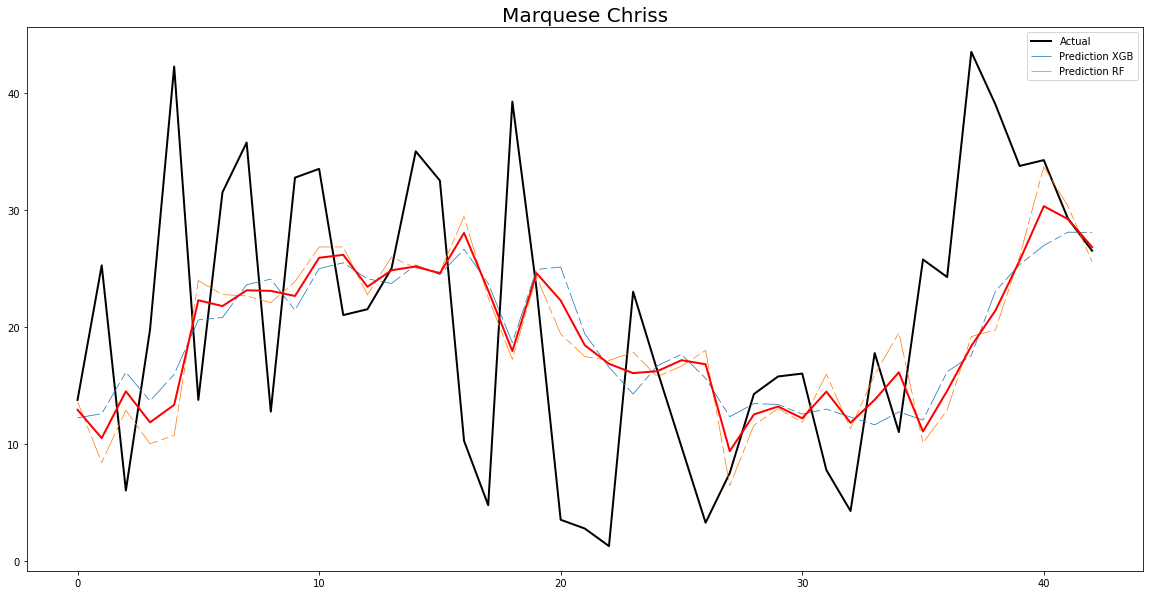

In [28]:
player = "Marquese Chriss"
df_player = df_test[df_test['Starters'] == player]
x_array, y_array, def_data = format(df_player, lb)

actual = scaler_y.inverse_transform((y_array.reshape(-1,1)))
x_array_LSTM = np.asarray(x_array).astype('float32')

_preds = model.predict(x_array_LSTM)
preds = scaler_y.inverse_transform(_preds)
x_array = np.hstack((def_data, preds))

preds = xg_reg.predict(x_array)
preds_rf = RF_reg.predict(x_array)


fig = plt.figure(figsize=(20,10))
ax = plt.subplot()

co = 10
ax.plot(actual, label = 'Actual', color = 'black', linewidth = 2)
ax.plot(preds, label = 'Prediction XGB', dashes=[30, 5, 10, 5], linewidth = .75)
ax.plot(preds_rf, label = 'Prediction RF', dashes=[30, 5, 10, 5], linewidth = .75)
ax.plot(.5*preds_rf + .5*preds, color = 'red', linewidth = 2)
plt.title(player, fontsize = 20)
ax.legend()


In [11]:
def prediciton_func(team, opp):

  url_team = "https://www.basketball-reference.com/teams/{}/2021.html".format(team)
  html_text = requests.get(url_team).text
  team = bs(html_text)

  table = team.find_all('table', id = 'roster')
  df_team = pd.read_html(str(table))[0]
  home_players = df_team['Player']
  home_players.values

  pred_list = []
  for player in home_players:
    data = df_scaled[df_scaled['Starters'] == player].sort_values(by='DATE').tail(lb)
    del data['Score'], data['Starters'], data['DATE']

    data = np.array([data.values])
    if data.shape != (1,lb,32):
      pred_list.append(0)
    else:
      prediction = model.predict(data)
      prediction = scaler_y.inverse_transform(prediction)
      prediction

      last = def_df[def_df['TEAM'] == opp].sort_values('DATE_DEF')['PTS_DEF'].tail(1).values[0]

      if np.isnan(last):
        def_stats = def_df[def_df['TEAM'] == opp].sort_values('DATE_DEF').tail(2).values[0,4:-1]
      else:
        def_stats = def_df[def_df['TEAM'] == opp].sort_values('DATE_DEF').tail(1).values[0,4:-1]

      x_data = np.hstack((np.array([def_stats]), prediction))
      pred_final = xg_reg.predict(x_data)
      pred_final_rf = RF_reg.predict(x_data)
      pred = .5*pred_final[0] + .5*pred_final_rf[0]

      pred_list.append(pred)

  return home_players, pred_list


def_df = pd.read_csv("DEF.csv")
url = "https://www.basketball-reference.com/leagues/NBA_2021_games.html"
html_text = requests.get(url).text
games = bs(html_text)

table_rows = games.find_all('tr')
l = []
df_list = []
for tr in (table_rows[1:]):
    td = list(tr.find_all('td'))
    home = td[1].get("csk")
    away = td[3].get("csk")

    if home[4:12] == "20201225":
      home_team = home[0:3]
      away_team = away[0:3]
      
      home_players, home_preds = prediciton_func(home_team, away_team)
      away_players, away_preds = prediciton_func(away_team, home_team)

      df_mid = pd.DataFrame(home_players)
      df_mid['Preds'] = home_preds

      df_mid_away = pd.DataFrame(away_players)
      df_mid_away['Preds'] = away_preds

      df_concat = pd.concat([df_mid, df_mid_away])
      df_list.append(df_concat)
    
    else:
      pass

df_final = pd.concat(df_list)
df_final
      

,Player,Preds
0,J.J. Redick,24.378790
1,Eric Bledsoe,29.641702
2,Lonzo Ball,32.590935
3,Zion Williamson,32.218371
4,Steven Adams,24.984598
...,...,...
12,Markus Howard (TW),0.000000
13,Zeke Nnaji,0.000000
14,Greg Whittington (TW),0.000000
15,Bol Bol,10.813776


In [32]:
from draftfast import rules
from draftfast.optimize import run
from draftfast.csv_parse import salary_download
from draftfast.rules import DRAFT_KINGS
from draftfast.lineup_constraints import LineupConstraints
from draftfast.orm import Player
from draftfast.optimize import run_multi

dk = pd.read_csv("DKSalaries.csv")
dk = pd.concat([dk.set_index('Name'),df_final.set_index('Player')], axis=1, join='inner')
del dk['AvgPointsPerGame']
dk.index = dk.index.set_names(['Name'])
dk.reset_index(inplace = True)
dk.columns = [*dk.columns[:-1], 'AvgPointsPerGame']

dk.to_csv("DKSalaries_new.csv")

player_pool = salary_download.generate_players_from_csvs(
  salary_file_location='DKSalaries_new.csv',
  game=DRAFT_KINGS,
)

constraints=LineupConstraints(
    #locked=['Anthony Davis'],
    banned=['Klay Thompson','Marquese Chriss'],
    #groups=[
    #    [('Kemba Walker', 'Stephen Curry'), (1)],
    #]
)

roster = run_multi(
    iterations=1,
    rule_set=rules.DK_NBA_RULE_SET,
    player_pool=player_pool,
    constraints=constraints,
    verbose=True,
  )
roster

Optimal roster for: NBA
+------------+-----------------------+------+-------------------------------+--------+--------------------+----------+--------+
| Position   | Player                | Team | Matchup                       | Salary |         Projection | vs. Avg. | Locked |
+------------+-----------------------+------+-------------------------------+--------+--------------------+----------+--------+
| PG/SG (PG) | Trey Burke            | DAL  | DAL@LAL 12/25/2020 08:00PM ET |   3200 | 20.441617965698242 |     0.00 |        |
| SG/SF (SG) | Luke Kennard          | LAC  | LAC@DEN 12/25/2020 10:30PM ET |   4000 |  22.88355484008789 |     0.00 |        |
| PG/SG (SG) | Damion Lee            | GS   | GS@MIL 12/25/2020 02:30PM ET  |   3700 | 23.957046699523925 |     0.00 |        |
| SF/PF (SF) | Jayson Tatum          | BOS  | BKN@BOS 12/25/2020 05:00PM ET |   9300 | 58.671240615844724 |     0.00 |        |
| PG/SF (SF) | Jimmy Butler          | MIA  | NO@MIA 12/25/2020 12:00PM ET  |   

([+------------+-----------------------+------+-------------------------------+--------+--------------------+----------+--------+
  | Position   | Player                | Team | Matchup                       | Salary |         Projection | vs. Avg. | Locked |
  +------------+-----------------------+------+-------------------------------+--------+--------------------+----------+--------+
  | PG/SG (PG) | Trey Burke            | DAL  | DAL@LAL 12/25/2020 08:00PM ET |   3200 | 20.441617965698242 |     0.00 |        |
  | SG/SF (SG) | Luke Kennard          | LAC  | LAC@DEN 12/25/2020 10:30PM ET |   4000 |  22.88355484008789 |     0.00 |        |
  | PG/SG (SG) | Damion Lee            | GS   | GS@MIL 12/25/2020 02:30PM ET  |   3700 | 23.957046699523925 |     0.00 |        |
  | SF/PF (SF) | Jayson Tatum          | BOS  | BKN@BOS 12/25/2020 05:00PM ET |   9300 | 58.671240615844724 |     0.00 |        |
  | PG/SF (SF) | Jimmy Butler          | MIA  | NO@MIA 12/25/2020 12:00PM ET  |   8000 |  